### Simulation with full account of volume adjustment

In [1]:
import re
import collections as col
import cPickle as pkl
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
import platform
if platform.system()=="Windows":
    files = !dir ..\..\results\vol*
else:
    files = !ls ../../results/vol*

In [3]:
filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    if match:
        if platform.system()=="Windows":
            filepaths[int(match.group(1).zfill(4))] = r"..\\..\\results\\" + file[file.index("polyphasic"):]
            # because the output of dir is more complex than that of ls
        else:
            filepaths[int(match.group(1).zfill(4))] = file

Function to replace numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [7]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

In [8]:
for time in filepaths:
    print time,
    replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")  # takes time, run only once

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


Load proteome:

In [9]:
results = {}
proteome = {}
for time in filepaths:
    print time, filepaths[time]
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-1}

0 ../../results/volume-adjusted polyphasic cell cycle v2 from 0 to 300, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_1525_200000_ribosomes_2100s.p
2400 ../../results/volume-adjusted polyphasic cell cycle v2 from 2400 to 2700, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_2237_286153_ribosomes_2100s.p
3300 ../../results/volume-adjusted polyphasic cell cycle v2 from 3300 to 3600, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190308_0108_318461_ribosomes_2100s.p
1800 ../../results/volume-adjusted polyphasic cell cycle v2 from 1800 to 2100, Teufel transcriptome, full exome, no decay, with ribo growth factor, updated initiation rates according to Shah_20190307_2055_264615_ribosomes_2100s.p
300 ../../results/volume-adjusted polyphasic cell cycle v2 from 300 to 600, Teufel tran

In [24]:
transcriptomes_dict = col.OrderedDict(sorted(
        pkl.load((open('../../parameters/transcriptome_time_dependent_v2.p'))).items()))

In [25]:
transcriptome_df = pd.DataFrame(transcriptomes_dict).transpose()
del transcriptome_df[0]
transcriptome_df.index = np.arange(0, 3601, 300)
transcriptome_df

,Q0010,Q0017,Q0032,Q0045,Q0050,Q0055,Q0060,Q0065,Q0070,Q0075,...,YPR196W,YPR197C,YPR198W,YPR199C,YPR200C,YPR201W,YPR202W,YPR203W,YPR204C-A,YPR204W
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
600,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0
900,0,0,0,0,0,0,0,0,0,0,...,1,0,3,1,0,0,0,0,0,0
1200,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,1,0,0,0,0,0
1500,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1800,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2100,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2400,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2700,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [26]:
translation_rate_shortlist = {}
genes = transcriptomes_dict[0].keys()[1:]

for gene in genes:
    translation_rate_shortlist[gene] = []
    for time in np.arange(0, 3600, 300):
        if gene in results[time]['timecourses']:
            rate = float(results[time]['timecourses'][gene][-1]-results[time]['timecourses'][gene][-301])/300.
        else:
            rate = 0.
        translation_rate_shortlist[gene].append(rate)

translation_ratedf = pd.DataFrame(translation_rate_shortlist, index=np.arange(0, 3600, 300))

In [29]:
translation_rate_per_mrna = translation_ratedf / transcriptome_df
translation_rate_per_mrna.dropna(axis=1, how='all', inplace=True)
translation_rate_per_mrna

,YAL001C,YAL002W,YAL003W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,...,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR194C,YPR196W,YPR198W,YPR199C,YPR200C
0,0.016667,0.015000,0.142830,0.0,0.066667,0.066667,0.031111,0.023333,0.013333,0.112687,...,0.072381,0.047778,0.047778,0.028889,0.060000,NaN,NaN,NaN,0.023333,NaN
300,0.023333,NaN,0.142222,0.0,0.066667,0.078333,0.026667,NaN,0.036667,0.114044,...,0.074545,0.045556,0.035000,0.040000,0.063333,NaN,NaN,0.050000,0.013333,0.0
600,0.011667,0.018333,0.097470,0.0,0.034545,0.054444,0.017778,NaN,0.015000,0.075251,...,0.044058,0.031111,0.015556,0.020833,0.044444,NaN,NaN,0.026667,NaN,0.0
900,0.016667,0.008333,0.097378,0.0,0.042593,0.048667,0.011111,0.010000,0.017778,0.078857,...,0.047576,0.035000,0.025833,0.025000,0.043333,NaN,0.0,0.028889,0.010000,NaN
1200,0.023333,0.013333,0.102576,0.0,0.039167,0.061111,0.018333,0.013333,0.030000,0.081754,...,0.049744,0.038000,0.023333,0.025833,0.037778,0.0,NaN,0.026667,0.010000,0.0
1500,0.046667,0.010000,0.201579,0.0,0.093333,0.123333,0.031667,NaN,NaN,0.164839,...,0.100417,0.088333,0.036667,0.050000,0.116667,NaN,NaN,0.070000,0.010000,NaN
1800,0.050000,0.013333,0.196579,0.0,0.105556,0.120000,0.036667,NaN,0.040000,0.165048,...,0.102857,0.100000,0.026667,0.060000,0.080000,NaN,NaN,0.080000,0.040000,NaN
2100,NaN,0.020000,0.197949,0.0,0.085556,0.126667,0.033333,NaN,0.066667,0.169314,...,0.105417,0.093333,0.053333,0.050000,0.093333,NaN,NaN,0.070000,NaN,NaN
2400,0.036667,0.010000,0.203951,0.0,0.095000,0.126667,0.038889,NaN,NaN,0.166869,...,0.107576,0.086667,0.060000,0.053333,0.096667,NaN,NaN,0.060000,0.023333,NaN
2700,0.020000,0.023333,0.202908,0.0,0.100000,0.113333,0.043333,NaN,0.056667,0.173089,...,0.113030,0.086667,0.050000,0.058333,0.103333,NaN,NaN,0.053333,0.033333,NaN


In [30]:
translation_rate_per_mrna.mean(axis=1, skipna=True)

0       0.038710
300     0.039834
600     0.025079
900     0.025352
1200    0.026130
1500    0.062328
1800    0.064209
2100    0.065175
2400    0.066439
2700    0.066398
3000    0.089871
3300    0.062143
3600         NaN
dtype: float64

In [31]:
import matplotlib.collections as collections

In [38]:
t = np.arange(0.0, 61.0, 2.5) * 60
print t
print t[::2]

[   0.  150.  300.  450.  600.  750.  900. 1050. 1200. 1350. 1500. 1650.
 1800. 1950. 2100. 2250. 2400. 2550. 2700. 2850. 3000. 3150. 3300. 3450.
 3600.]
[   0.  300.  600.  900. 1200. 1500. 1800. 2100. 2400. 2700. 3000. 3300.
 3600.]


Transcript abundance and translational efficiency:

Values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes_new_CC_phases.xlsx linearly interpolated (sheet nostress_WT_R1_rounded, bottom):

In [34]:
equidistant_values = [42123, 42167, 72667, 72764, 72928, 27655, 27355, 27315, 27222, 27559, 16741, 32065, 22535]

Interpolate these values:

In [43]:
interpolated_values = np.interp(t, t[::2], equidistant_values)

In [44]:
interpolated_values

array([42123. , 42145. , 42167. , 57417. , 72667. , 72715.5, 72764. ,
       72846. , 72928. , 50291.5, 27655. , 27505. , 27355. , 27335. ,
       27315. , 27268.5, 27222. , 27390.5, 27559. , 22150. , 16741. ,
       24403. , 32065. , 27300. , 22535. ])

In [57]:
t/60

array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
       55. , 57.5, 60. ])

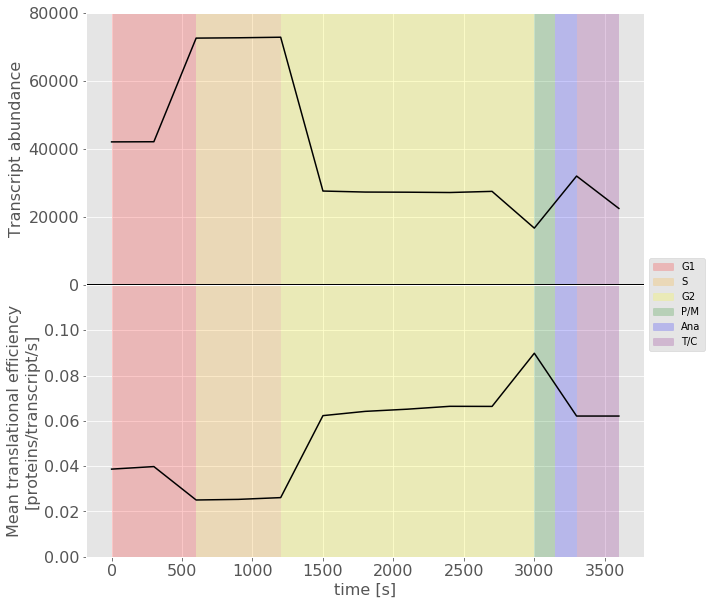

In [62]:
plt.rcParams['figure.figsize'] = (10, 10)

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5) * 60
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes_new_CC_phases.xlsx linearly interpolated (sheet nostress_WT_R1_rounded)
y1 = interpolated_values
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
#y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0) * 60, y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=16)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 10.1*60, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 20.1*60, tt >= 9.9*60])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 50.1*60, tt >= 19.9*60])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6*60, tt >= 49.9*60])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 55.1*60, tt >= 52.4*60])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t >= 54.9*60, facecolor='purple', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
# old phases:
#red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
#orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
#yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
#green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
#blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
#purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
#grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

red_patch = mpatches.Patch(color='red', label='G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='S', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='G2', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='P/M', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='Ana', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='T/C', alpha=0.2)

plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.74), fancybox=True, framealpha=1.0)

# plt.text(1.0, 5000, "early G1", fontsize=16, weight="bold")

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ax = ax2
pos = np.arange(0.0, 0.11, 0.02)
ax.set_yticks(pos)
ax.set_yticklabels(["%.2f" % round(p,2) for p in pos], fontsize=16)
ax.set_ylabel("Mean translational efficiency\n[proteins/transcript/s]", fontsize=16)
ax.set_xlabel("time [s]", fontsize=16)


collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=t <= 10.1*60, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 20.1*60, tt >= 9.9*60])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 50.1*60, tt >= 19.9*60])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 52.6*60, tt >= 49.9*60])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=[np.all(np.array([tt < 55.1*60, tt >= 52.4*60])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=0.12, where=t > 54.9*60, facecolor='purple', alpha=0.2)
ax.add_collection(collection)

plt.ylim([0, 0.12])

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

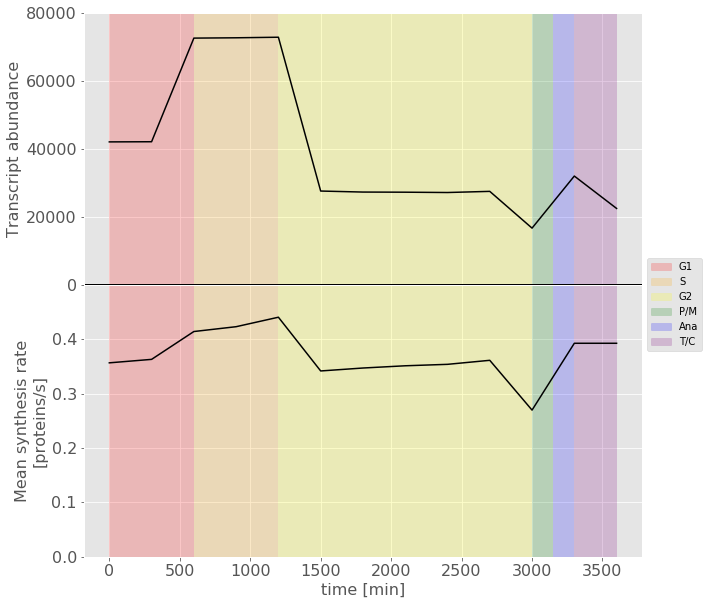

In [69]:
plt.rcParams['figure.figsize'] = (10, 10)

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5) * 60
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes_new_CC_phases.xlsx linearly interpolated (sheet nostress_WT_R1_rounded)
y1 = interpolated_values
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
#y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_ratedf.mean(axis=1, skipna=True).values
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0) * 60, y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=16)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 10.1*60, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 20.1*60, tt >= 9.9*60])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 50.1*60, tt >= 19.9*60])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6*60, tt >= 49.9*60])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 55.1*60, tt >= 52.4*60])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t >= 54.9*60, facecolor='purple', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
# old phases:
#red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
#orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
#yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
#green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
#blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
#purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
#grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

red_patch = mpatches.Patch(color='red', label='G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='S', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='G2', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='P/M', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='Ana', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='T/C', alpha=0.2)

plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.74), fancybox=True, framealpha=1.0)

# plt.text(1.0, 5000, "early G1", fontsize=16, weight="bold")

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ymax = 0.5

ax = ax2
pos = np.arange(0.0, ymax, 0.1)
ax.set_yticks(pos)
ax.set_yticklabels(["%.1f" % round(p,1) for p in pos], fontsize=16)
ax.set_ylabel("Mean synthesis rate\n[proteins/s]", fontsize=16)
ax.set_xlabel("time [min]", fontsize=16)


collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=t <= 10.1*60, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 20.1*60, tt >= 9.9*60])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 50.1*60, tt >= 19.9*60])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 52.6*60, tt >= 49.9*60])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=[np.all(np.array([tt < 55.1*60, tt >= 52.4*60])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=ymax, where=t > 54.9*60, facecolor='purple', alpha=0.2)
ax.add_collection(collection)

plt.ylim([0, ymax])

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.show()

Only transcript abundance:

In [70]:
matplotlib.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", l

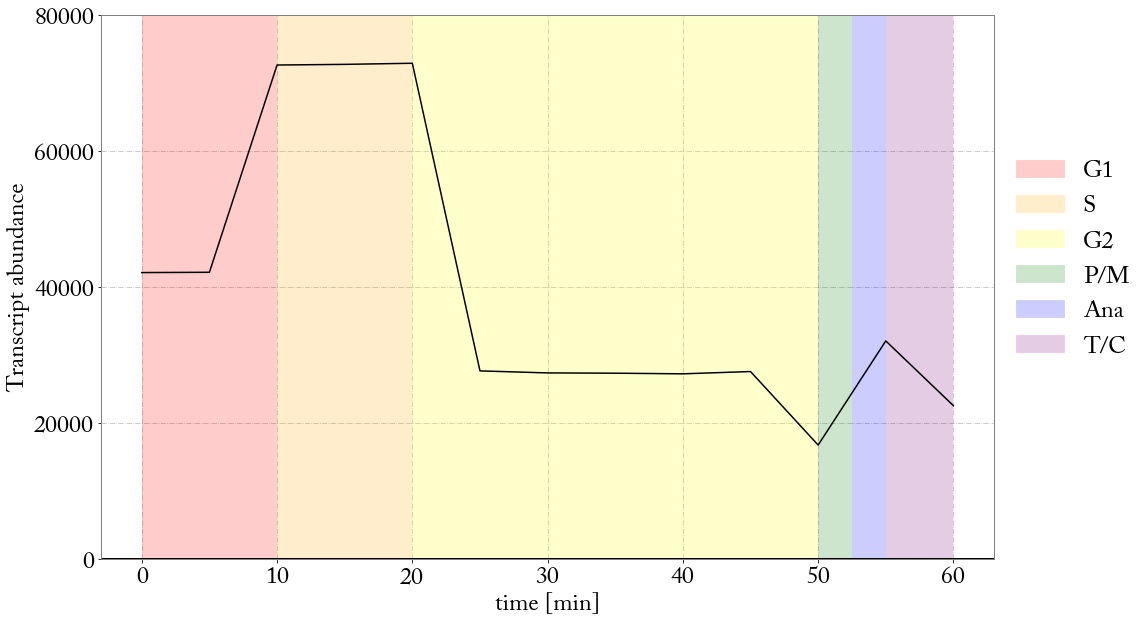

In [75]:
t = np.arange(0.0, 61.0, 2.5)

plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='grey'
plt.rcParams['grid.color']='grey'
plt.rcParams['grid.alpha']='0.5'
plt.rcParams['grid.linestyle']='-.'

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes_new_CC_phases.xlsx linearly interpolated (sheet nostress_WT_R1_rounded)
y1 = interpolated_values
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
#y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]


#######################################################################################################################
f, ax1 = plt.subplots(1)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=24)
ax.yaxis.label.set_color('black')
plt.tick_params(axis='both', which='major', labelsize=24)

myalpha = 0.1
pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=24)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 10.1, facecolor='red', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 20.1, tt >= 9.9])) for tt in t], facecolor='orange', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 50.1, tt >= 19.9])) for tt in t], facecolor='yellow', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt >= 49.9])) for tt in t], facecolor='green', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 55.1, tt >= 52.4])) for tt in t], facecolor='blue', alpha=0.2)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t >= 54.9, facecolor='purple', alpha=0.2)
ax.add_collection(collection)

import matplotlib.patches as mpatches
# old phases:
#red_patch = mpatches.Patch(color='red', label='early G1', alpha=0.2)
#orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=0.2)
#yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=0.2)
#green_patch = mpatches.Patch(color='green', label='G2', alpha=0.2)
#blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=0.2)
#purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=0.2)
#grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=0.2)

red_patch = mpatches.Patch(color='red', label='G1', alpha=0.2)
orange_patch = mpatches.Patch(color='orange', label='S', alpha=0.2)
yellow_patch = mpatches.Patch(color='yellow', label='G2', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='P/M', alpha=0.2)
blue_patch = mpatches.Patch(color='blue', label='Ana', alpha=0.2)
purple_patch = mpatches.Patch(color='purple', label='T/C', alpha=0.2)

lgd = plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch], 
           loc='lower left', bbox_to_anchor=(1, 0.33), fancybox=True, framealpha=0.0, fontsize=24)

ax1.set_xlabel("time [min]", fontsize=24)
ax1.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#plt.tight_layout()
plt.savefig('time_resolved_transcriptome.pgf', bbox_extra_artists=(lgd,), bbox_inches='tight')

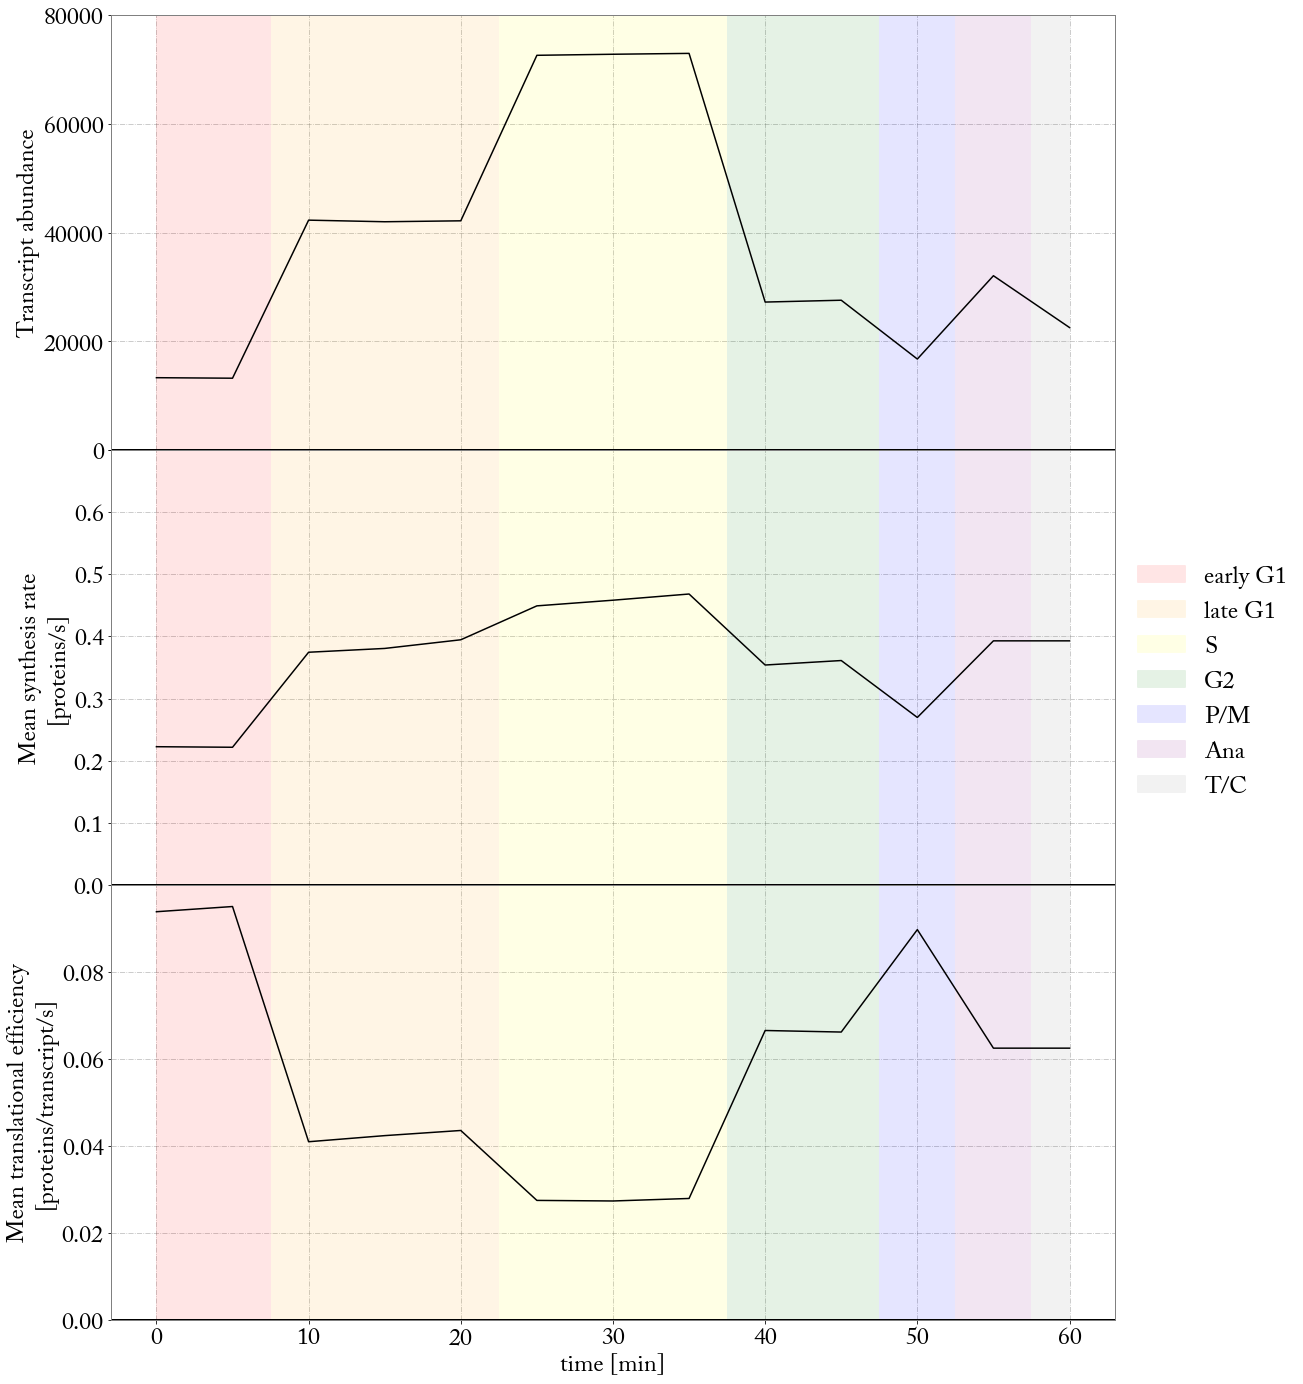

In [17]:
t = np.arange(0.0, 61.0, 2.5)

plt.rcParams['figure.figsize'] = (18, 24)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='grey'
plt.rcParams['grid.color']='grey'
plt.rcParams['grid.alpha']='0.5'
plt.rcParams['grid.linestyle']='-.'

# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_ratedf.mean(axis=1, skipna=True).values
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=24)
ax.yaxis.label.set_color('black')
plt.tick_params(axis='both', which='major', labelsize=24)

myalpha = 0.1
pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=24)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=myalpha)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=myalpha)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=myalpha)
green_patch = mpatches.Patch(color='green', label='G2', alpha=myalpha)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=myalpha)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=myalpha)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=myalpha)

#ax1.set_xlabel("time [min]", fontsize=24)
#ax1.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#######################################################################################################################
ax2.plot(x2, y2, color='black')

ymax = 0.8

ax = ax2
#plt.tick_params(axis='both', which='major', labelsize=24)

pos = np.arange(0.0, ymax, 0.1)
ax.set_yticks(pos)
ax.yaxis.label.set_color('black')
ax.set_yticklabels(["%.1f" % round(p,1) for p in pos[:-1]], fontsize=24) # the last one always overlapped
ax.set_ylabel("Mean synthesis rate\n[proteins/s]", fontsize=24)
#ax.set_xlabel("time [min]", fontsize=24)
ax.tick_params(axis='y', colors='black')

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t < 7.6, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t > 57.4, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

plt.ylim([0, ymax])

#######################################################################################################################

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

ax3.plot(x2, y2, color='black')

ymax = 0.1

ax = ax3
#plt.tick_params(axis='both', which='major', labelsize=24)

pos = np.arange(0.0, 0.1, 0.02)

ax.set_yticks(pos)
ax.yaxis.label.set_color('black')
#ax.set_yticklabels(["%.001f" % round(p, 3) for p in pos], fontsize=24)
ax.set_ylabel("Mean translational efficiency\n[proteins/transcript/s]", fontsize=24)
#ax.set_xlabel("time [min]", fontsize=24)
ax.tick_params(axis='y', colors='black')

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t < 7.6, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t > 57.4, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

plt.ylim([0, ymax])

ax.xaxis.label.set_color('black')
ax.set_xlabel("time [min]", fontsize=24)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#######################################################################################################################
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

lgd = plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 1.15), fancybox=True, framealpha=0.0, fontsize=24)

#plt.tight_layout()
plt.savefig('time_resolved_mean_results.pgf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Figure 6 in paper:

In [18]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

[]

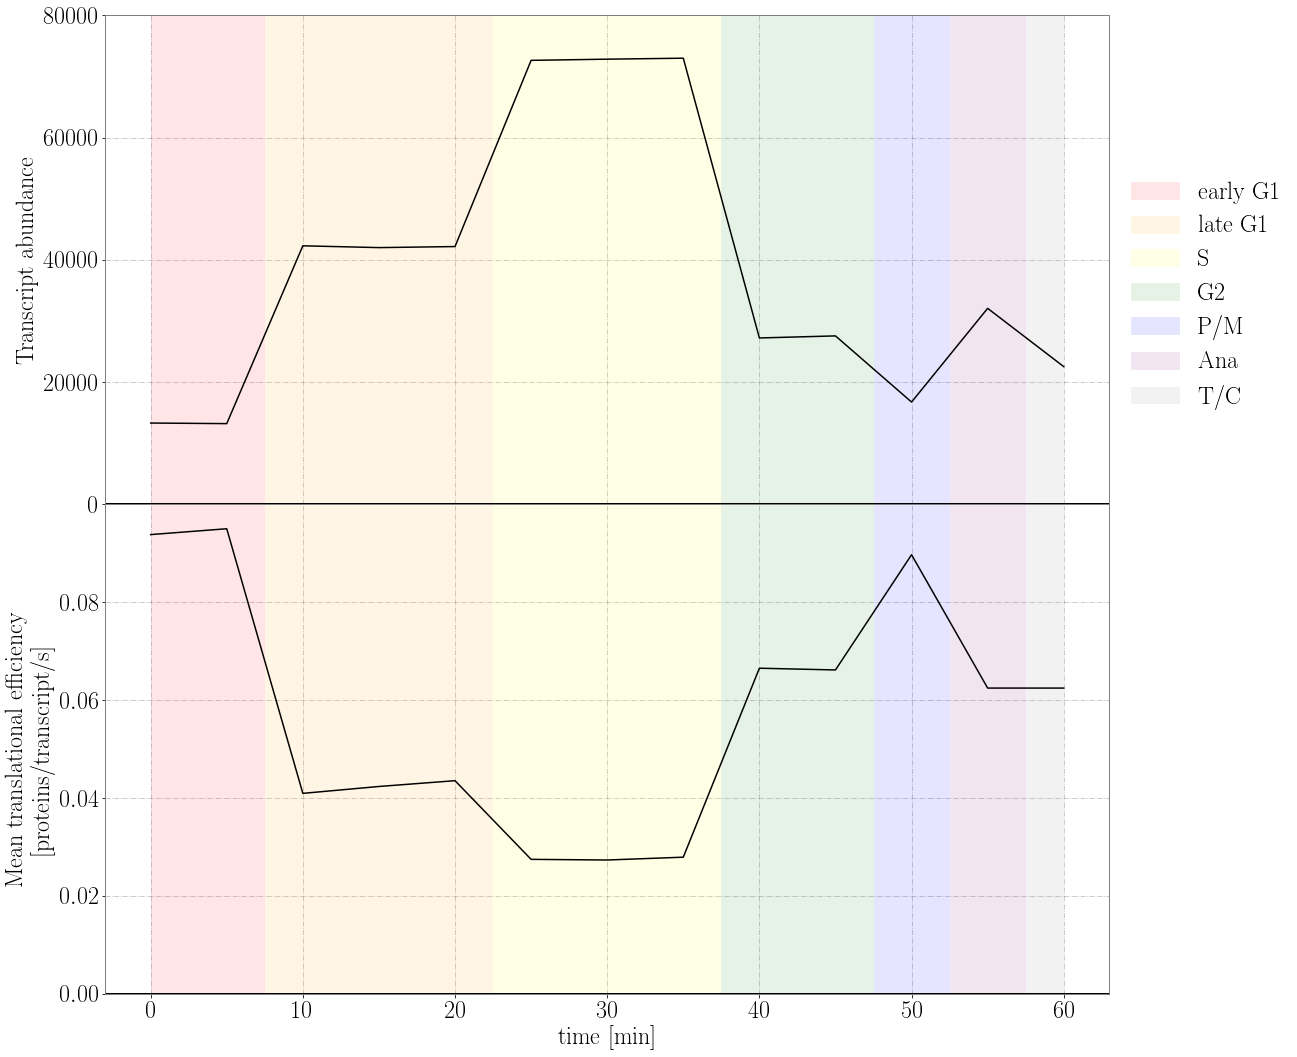

In [23]:
t = np.arange(0.0, 61.0, 2.5)

plt.rcParams['figure.figsize'] = (18, 18)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='grey'
plt.rcParams['grid.color']='grey'
plt.rcParams['grid.alpha']='0.5'
plt.rcParams['grid.linestyle']='-.'

#pgf_with_rc_fonts = {
#    "font.family": "serif",
#    "font.serif": [u'Times New Roman'],                   # use latex default serif font
#    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#}


# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5)
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_ratedf.mean(axis=1, skipna=True).values
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax3) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=24)
ax.yaxis.label.set_color('black')
plt.tick_params(axis='both', which='major', labelsize=24)

myalpha = 0.1
pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=24)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=myalpha)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=myalpha)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=myalpha)
green_patch = mpatches.Patch(color='green', label='G2', alpha=myalpha)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=myalpha)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=myalpha)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=myalpha)

#ax1.set_xlabel("time [min]", fontsize=24)
#ax1.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#######################################################################################################################

#######################################################################################################################

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0), y2)

ax3.plot(x2, y2, color='black')

ymax = 0.1

ax = ax3
#plt.tick_params(axis='both', which='major', labelsize=24)

pos = np.arange(0.0, 0.1, 0.02)

ax.set_yticks(pos)
ax.yaxis.label.set_color('black')
#ax.set_yticklabels(["%.001f" % round(p, 3) for p in pos], fontsize=24)
ax.set_ylabel("Mean translational efficiency\n[proteins/transcript/s]", fontsize=24)
#ax.set_xlabel("time [min]", fontsize=24)
ax.tick_params(axis='y', colors='black')

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t < 7.6, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 22.6, tt > 7.4])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 37.6, tt > 22.4])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 47.6, tt > 37.4])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 52.6, tt > 47.4])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 57.6, tt > 52.4])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t > 57.4, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

plt.ylim([0, ymax])

ax.xaxis.label.set_color('black')
ax.set_xlabel("time [min]", fontsize=24)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#######################################################################################################################
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

lgd = plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 1.15), fancybox=True, framealpha=0.0, fontsize=24)

#plt.tight_layout()
#plt.savefig('time_resolved_mean_results.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.plot()

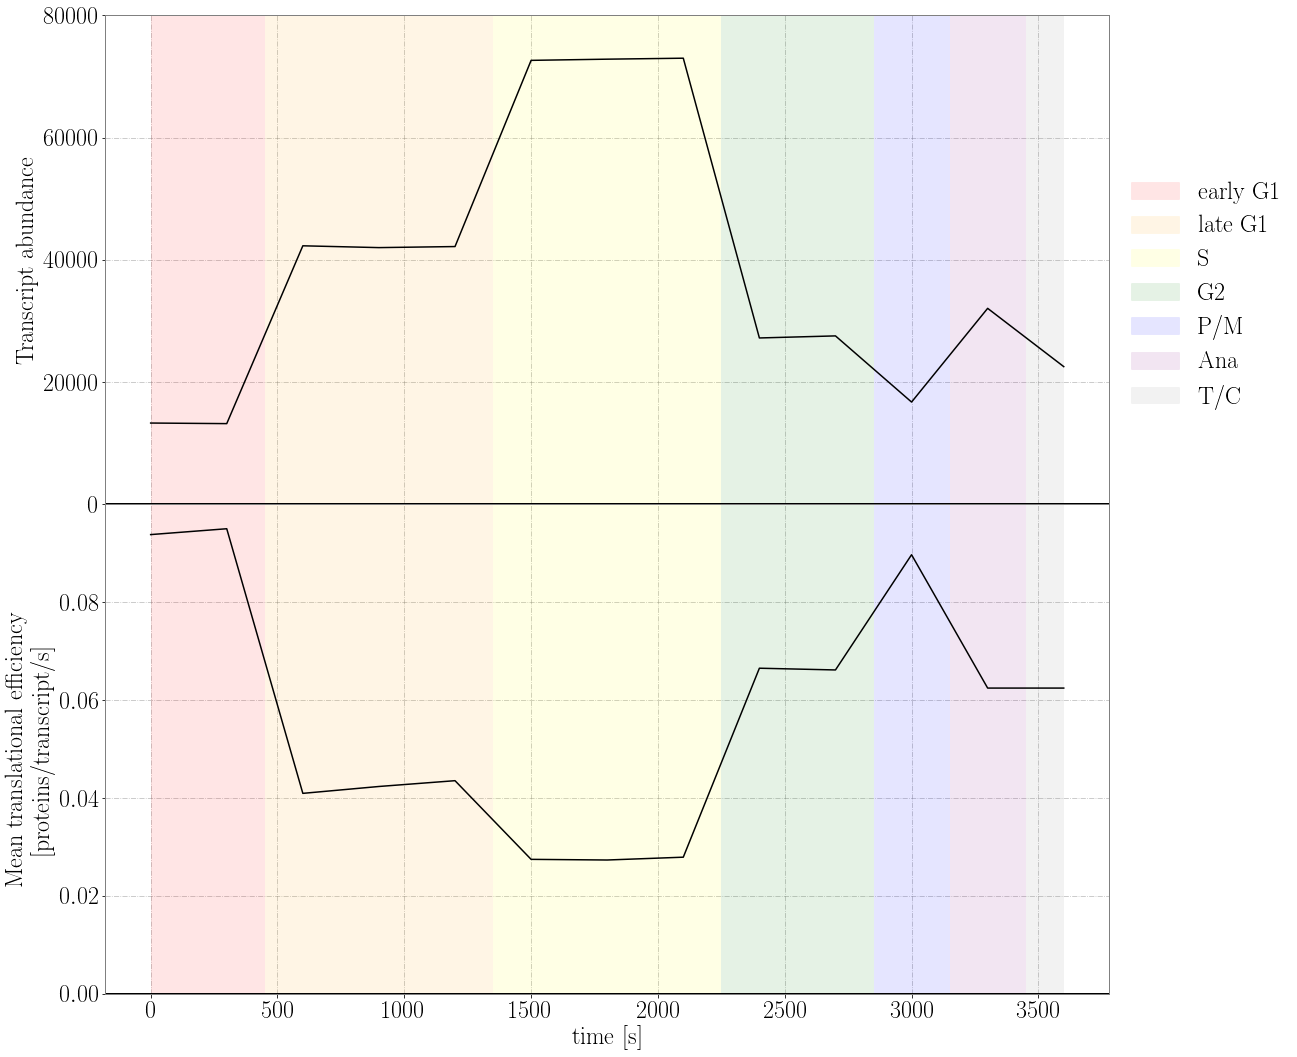

In [24]:
t = np.arange(0.0, 61.0, 2.5)* 60

plt.rcParams['figure.figsize'] = (18, 18)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='grey'
plt.rcParams['grid.color']='grey'
plt.rcParams['grid.alpha']='0.5'
plt.rcParams['grid.linestyle']='-.'

#pgf_with_rc_fonts = {
#    "font.family": "serif",
#    "font.serif": [u'Times New Roman'],                   # use latex default serif font
#    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#}


# Simple data to display in various forms
x1 = np.arange(0.0, 61.0, 2.5) * 60
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_7_genes.xlsx linearly interpolated
y1 = [13310, (13310+13214.0)/2, 13214, (13214.0+42291)/2, 42291, (42291.0+41996)/2, 41996, (41996.0+42168)/2, 42168, (42168.0+72615)/2, 72615, (72615.0+72809)/2, 72809, (72809.0+72968)/2, 72968, (72968.0+27222)/2, 27222, (27222.0+27559)/2, 27559, (27559.0+16741)/2, 16741, (16741.0+32065)/2, 32065, (32065.0+22535)/2, 22535]
# values from Excel spreadsheet FISH_RNAseq_combined_FACS_phases_5_genes.xlsx linearly interpolated
# y1 = [15302, 15302, 15302, (15302.0+42149)/2, 42149, 42149, 42149, 42149, 42149, (42149.0+72909)/2, 72909, 72909, 72909, 72909, 72909, (72909.0+27471)/2, 27471, 27471, 27471, (27471.0+16858)/2, 16858, (16858.0+32244)/2, 32244, (32244.0+32946)/2, 32946]

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0)*60, y2)

#######################################################################################################################
# Two subplots sharing both x/y axes
f, (ax1, ax3) = plt.subplots(2, sharex=True, sharey=False)

#######################################################################################################################
ax1.plot(x1, y1, color='black')
ax = ax1
ax.set_ylabel("Transcript abundance", fontsize=24)
ax.yaxis.label.set_color('black')
plt.tick_params(axis='both', which='major', labelsize=24)

myalpha = 0.1
pos = [0, 20000, 40000, 60000, 80000]
ax.set_yticks(pos)
ax.set_yticklabels(pos, fontsize=24)

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t < 7.6*60, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 22.6*60, tt > 7.4*60])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 37.6*60, tt > 22.4*60])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 47.6*60, tt > 37.4*60])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 52.6*60, tt > 47.4*60])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=[np.all(np.array([tt < 57.6*60, tt > 52.4*60])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=80000, where=t > 57.4*60, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='early G1', alpha=myalpha)
orange_patch = mpatches.Patch(color='orange', label='late G1', alpha=myalpha)
yellow_patch = mpatches.Patch(color='yellow', label='S', alpha=myalpha)
green_patch = mpatches.Patch(color='green', label='G2', alpha=myalpha)
blue_patch = mpatches.Patch(color='blue', label='P/M', alpha=myalpha)
purple_patch = mpatches.Patch(color='purple', label='Ana', alpha=myalpha)
grey_patch = mpatches.Patch(color='grey', label='T/C', alpha=myalpha)

#ax1.set_xlabel("time [min]", fontsize=24)
#ax1.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#######################################################################################################################

#######################################################################################################################

x2 = x1
# values from simulation
y2 = translation_rate_per_mrna.mean(axis=1, skipna=True).values[:-1]
y2 = np.interp(x2, np.arange(0.0, 60.0, 5.0)*60, y2)

ax3.plot(x2, y2, color='black')

ymax = 0.1

ax = ax3
#plt.tick_params(axis='both', which='major', labelsize=24)

pos = np.arange(0.0, 0.1, 0.02)

ax.set_yticks(pos)
ax.yaxis.label.set_color('black')
#ax.set_yticklabels(["%.001f" % round(p, 3) for p in pos], fontsize=24)
ax.set_ylabel("Mean translational efficiency\n[proteins/transcript/s]", fontsize=24)
#ax.set_xlabel("time [min]", fontsize=24)
ax.tick_params(axis='y', colors='black')

ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t < 7.6*60, facecolor='red', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 22.6*60, tt > 7.4*60])) for tt in t], facecolor='orange', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 37.6*60, tt > 22.4*60])) for tt in t], facecolor='yellow', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 47.6*60, tt > 37.4*60])) for tt in t], facecolor='green', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 52.6*60, tt > 47.4*60])) for tt in t], facecolor='blue', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=[np.all(np.array([tt < 57.6*60, tt > 52.4*60])) for tt in t], facecolor='purple', alpha=myalpha)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=t > 57.4*60, facecolor='grey', alpha=myalpha)
ax.add_collection(collection)

plt.ylim([0, ymax])

ax.xaxis.label.set_color('black')
ax.set_xlabel("time [s]", fontsize=24)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#######################################################################################################################
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

lgd = plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch, purple_patch, grey_patch], 
           loc='lower left', bbox_to_anchor=(1, 1.15), fancybox=True, framealpha=0.0, fontsize=24)

#plt.tight_layout()
plt.savefig('time_resolved_mean_results.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')